In [59]:
import numpy as np
from skimage.color import rgb2gray
import cv2

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

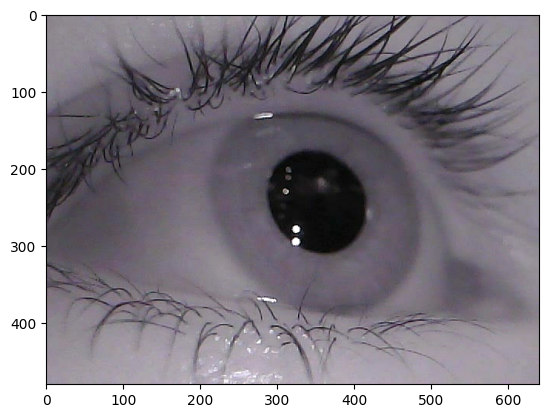

(480, 640, 3)
(480, 640)


In [60]:
image = imread('eye.png')
plt.imshow(image)
plt.show()
print(image.shape)
print(image[:,:,2].shape)

In [61]:
image = rgb2gray(image)
print(image.shape)

(480, 640)


In [62]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from skimage.transform import resize


def gaussian_smoothing(img):
    smoothed_img = gaussian_filter(img, sigma=5)
    return smoothed_img

def gradient(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -1, -2]])
    sobel_x_img = convolve(img, sobel_x, mode='constant')
    sobel_y_img = convolve(img, sobel_y, mode='constant')
    g_magnitude = np.sqrt(sobel_x_img ** 2 + sobel_y_img ** 2)
    g_dir = np.arctan2(sobel_x_img, sobel_y_img)
    return g_magnitude, g_dir

def non_maximum_suppression(g_magnitude, g_dir):
    g_dir[g_dir < 0] += np.pi
    g_dir_hat = np.floor_divide(g_dir, np.pi / 4)
    g_max = np.zeros_like(g_magnitude)
    for x in range(1, g_magnitude.shape[0] - 1):
        for y in range(1, g_magnitude.shape[1] - 1):
            magnitude = g_magnitude[x, y]
            dir_hat = g_dir_hat[x, y]
            if dir_hat == 0:  # east/west
                if np.greater_equal(magnitude, g_magnitude[x, y-1]) and np.greater_equal(magnitude, g_magnitude[x, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 1: #northeast/southwest
                if np.greater_equal(magnitude, g_magnitude[x+1, y-1]) and np.greater_equal(magnitude, g_magnitude[x-1, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 2: #nort/south
                if np.greater_equal(magnitude, g_magnitude[x+1, y]) and np.greater_equal(magnitude, g_magnitude[x-1, y]):
                    g_max[x, y] = magnitude
            elif dir_hat == 3: #nortwest/southeast
                if np.greater_equal(magnitude, g_magnitude[x+1, y+1]) and np.greater_equal(magnitude, g_magnitude[x-1, y-1]):
                    g_max[x, y] = magnitude
    return g_max

def double_thresholding(g_max, thresh_lo, thresh_hi):
    thresh_img = np.zeros_like(g_max)
    for x in range(g_max.shape[0]):
      for y in range(g_max.shape[1]):
          mag = g_max[x, y]   
          if mag > thresh_hi:
              thresh_img[x, y] = 255 #strong
          elif mag > thresh_lo:
              thresh_img[x, y] = 128 #weak
    return thresh_img

def connectivity(thresh_img):
    edge_img = np.zeros_like(thresh_img)
    for x in range(thresh_img.shape[0]):
      for y in range(thresh_img.shape[1]):
        edge = thresh_img[x,y]
        if edge == 255:
          edge_img[x,y] = edge
        if edge == 128:
          if thresh_img[x-1,y-1]==255 or thresh_img[x-1,y]==255 or thresh_img[x,y-1]==255 or thresh_img[x+1,y]==255 or thresh_img[x+1,y+1]==255:
            edge_img[x,y] = edge
    return edge_img

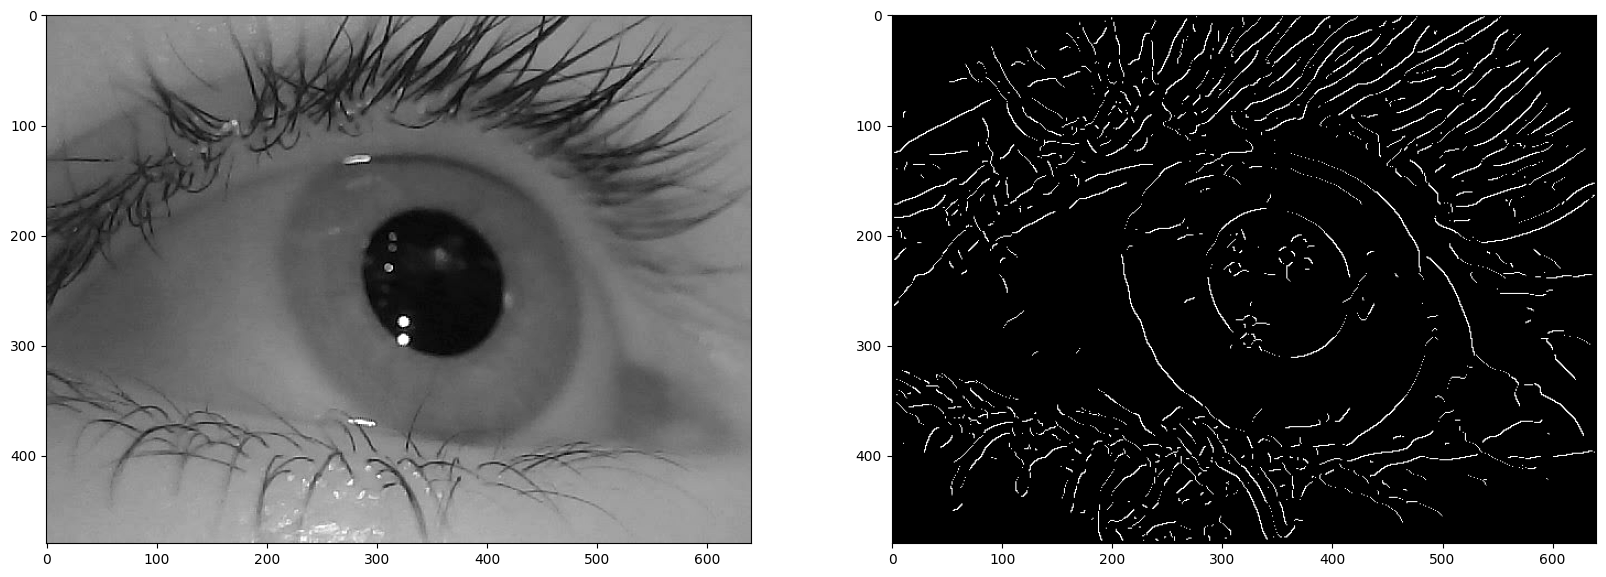

In [72]:
def canny_edge_detector(img, thresh_lo=0.01, thresh_hi=0.02):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img


edges = canny_edge_detector(image)

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)
axes[0].imshow(image, cmap='gray')
axes[1].imshow(edges, cmap='gray')

In [73]:
# # Load the image
# image = cv2.imread('eye.png')

# # Convert the image to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Blur the image to reduce noise
# blur = cv2.GaussianBlur(gray, (3, 3), 0)

# # Use the Hough transform to detect circles in the image
# circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=30, param2=55, minRadius=25, maxRadius=150)

# print(circles[0].shape)

# if circles.shape[1]>100:
#         print('nope, too big')
# else:
#      # Iterate over the detected circles
#     for circle in circles[0]:
#         # Unpack the circle tuple
#         x, y, r = circle
#         x = int(x)
#         y = int(y)
#         r = int(r)
#         # print(circle)
#         # Draw a circle centered at (x, y) with radius r
#         cv2.circle(image, (x, y), r, (0, 255, 0), 2)

#     # Display the image
#     cv2.imshow('Circles', image)
#     cv2.waitKey(0) 
#     cv2.destroyAllWindows()   


In [74]:
# #accumulator 
# import math

# def hough(img, edge, min_radius, max_radius,accumulator_resolution=1):
#     print(img.shape[0:2])
#     image_height, image_width = img.shape[0:2]
#     accumulator = np.zeros((image_height, image_width), dtype=np.uint8)

#     # Set the center of the image
#     center_x = image_width // 2
#     center_y = image_height // 2
#     print('running')

#     # Iterate over the edge pixels in the image
#     for y in tqdm(range(image_height)):
#         for x in range(image_width):
#             if edge[y, x] > 0:  # If this pixel is an edge pixel
#                 # Compute the parameters of the circles that pass through this pixel
#                 for r in range(min_radius, max_radius+1, accumulator_resolution):
#                     for theta in range(360):
#                         a = x - r * math.cos(theta)
#                         b = y - r * math.sin(theta)
#                         if 0 <= a < image_width and 0 <= b < image_height:  # Check if the circle is within the bounds of the image
#                             accumulator[int(b), int(a)] += 1  # Increment the accumulator array
#     # Find the maximum value in the accumulator array
#     max_value = np.amax(accumulator)
#     print('still running')

#     # Set the threshold for the accumulator array
#     threshold = 0.9 * max_value

#     # Initialize a list to store the detected circles
#     circles = []

#     # Find the circles in the accumulator array
#     for y in range(image_height):
#         for x in range(image_width):
#             if accumulator[y, x] > threshold:  # If the accumulator value is above the threshold
#                 # Append the detected circle to the list
#                 circles.append((x, y, r))

#     return circles

# circles = hough(image, edges, 25, 150)

# print(circles)


# # Initialize an output image as a copy of the input image
# output_image = np.copy(image)

# # Draw the circles on the output image
# for circle in circles:
#     # Unpack the circle tuple
#     x, y, r = circle
#     # Draw the circle on the output image
#     cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)

# # Display the output image
# cv2.imshow('Circles', output_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()




In [75]:
# print(len(circles))
# for i in range(len(circles)):
#     if circles[i][0]>300 and circles[i][0]<400:
#         if circles[i][1]>200 and circles[i][1]<300:
#             if circles[i][2]<150:
#                 print(circles[i])



100%|██████████| 10/10 [00:00<00:00, 2985.06it/s]
/var/folders/t4/9fy1pq9d6tjchq8lc65_mnn80000gn/T/ipykernel_77970/2892157343.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(111).add_artist(circle[-1])


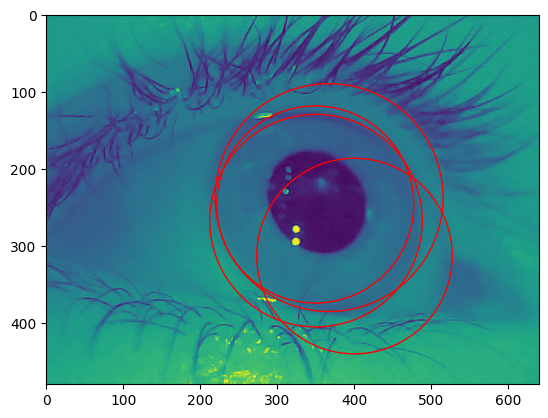

In [76]:
def detectCircles(img,threshold,region,radius):
    (M,N) = img.shape
    [R_max,R_min] = radius
    R = R_max - R_min
    #Initializing accumulator array.
    #Accumulator array is a 3 dimensional array with the dimensions representing
    #the radius, X coordinate and Y coordinate resectively.
    #Also appending a padding of 2 times R_max to overcome the problems of overflow
    A = np.zeros((R_max,M+2*R_max,N+2*R_max))
    B = np.zeros((R_max,M+2*R_max,N+2*R_max))

    #Precomputing all angles to increase the speed of the algorithm
    theta = np.arange(0,360)*np.pi/180
    edges = np.argwhere(img[:,:])                                               #Extracting all edge coordinates
    for val in tqdm(range(R)):
        r = R_min+val
        #Creating a Circle Blueprint
        bprint = np.zeros((2*(r+1),2*(r+1)))
        (m,n) = (r+1,r+1)                                                       #Finding out the center of the blueprint
        for angle in theta:
            x = int(np.round(r*np.cos(angle)))
            y = int(np.round(r*np.sin(angle)))
            bprint[m+x,n+y] = 1
        constant = np.argwhere(bprint).shape[0]
        for x,y in edges:                                                       #For each edge coordinates
            #Centering the blueprint circle over the edges
            #and updating the accumulator array
            X = [x-m+R_max,x+m+R_max]                                           #Computing the extreme X values
            Y= [y-n+R_max,y+n+R_max]                                            #Computing the extreme Y values
            A[r,X[0]:X[1],Y[0]:Y[1]] += bprint
        A[r][A[r]<threshold*constant/r] = 0

    for r,x,y in tqdm(np.argwhere(A)):
        temp = A[r-region:r+region,x-region:x+region,y-region:y+region]
        try:
            p,a,b = np.unravel_index(np.argmax(temp),temp.shape)
        except:
            continue
        B[r+(p-region),x+(a-region),y+(b-region)] = 1

    return B[:,R_max:-R_max,R_max:-R_max]

def displayCircles(A):
    img = image
    fig = plt.figure()
    plt.imshow(img)
    circleCoordinates = np.argwhere(A)                                          #Extracting the circle information
    circle = []
    for r,x,y in circleCoordinates:
        circle.append(plt.Circle((y,x),r,color=(1,0,0),fill=False))
        fig.add_subplot(111).add_artist(circle[-1])
    plt.show()
#set display to True to display the edge image
#detectCircles takes a total of 4 parameters. 3 are required.
#The first one is the edge image. Second is the thresholding value and the third is the region size to detect peaks.
#The fourth is the radius range.
res = detectCircles(edges,20,15,radius=[150,20])    #res = detectCircles(edges,20,15,radius=[150,25])
displayCircles(res)